<a href="https://colab.research.google.com/github/LyubovKazlova/TS/blob/main/TS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
!pip install --upgrade mplfinance

In [159]:
from mplfinance.original_flavor import candlestick_ohlc
import yfinance as yf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import pandas as pd
import warnings
import numpy as np
import seaborn as sns

import scipy.stats as scs
from scipy.stats import boxcox

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics

from itertools import product
from tqdm import tqdm_notebook

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [160]:
def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period = '1d', start = '2017-1-1', end = '2023-9-1')
    return tickerDf.iloc[:, :5]

In [161]:
# get price data (return pandas dataframe)
df_dis = get_price_data('DIS')

In [162]:
df_dis.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,100.837416,102.369607,100.751226,101.584358,8884300
2017-01-04 00:00:00-05:00,102.120627,102.944181,101.747156,102.886726,8322000
2017-01-05 00:00:00-05:00,102.628170,103.059104,102.264277,102.829269,6303000
2017-01-06 00:00:00-05:00,103.442144,104.715780,103.183589,104.361465,9551300
2017-01-09 00:00:00-05:00,103.978401,104.217806,103.528318,103.767723,6195200


In [163]:
# get price data (return pandas dataframe)
df_am = get_price_data('AMZN')

In [164]:
df_am.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03 00:00:00-05:00,37.896000,37.938000,37.384998,37.683498,70422000
2017-01-04 00:00:00-05:00,37.919498,37.984001,37.709999,37.859001,50210000
2017-01-05 00:00:00-05:00,38.077499,39.119999,38.013000,39.022499,116602000
2017-01-06 00:00:00-05:00,39.118000,39.972000,38.924000,39.799500,119724000
2017-01-09 00:00:00-05:00,39.900002,40.088501,39.588501,39.846001,68922000


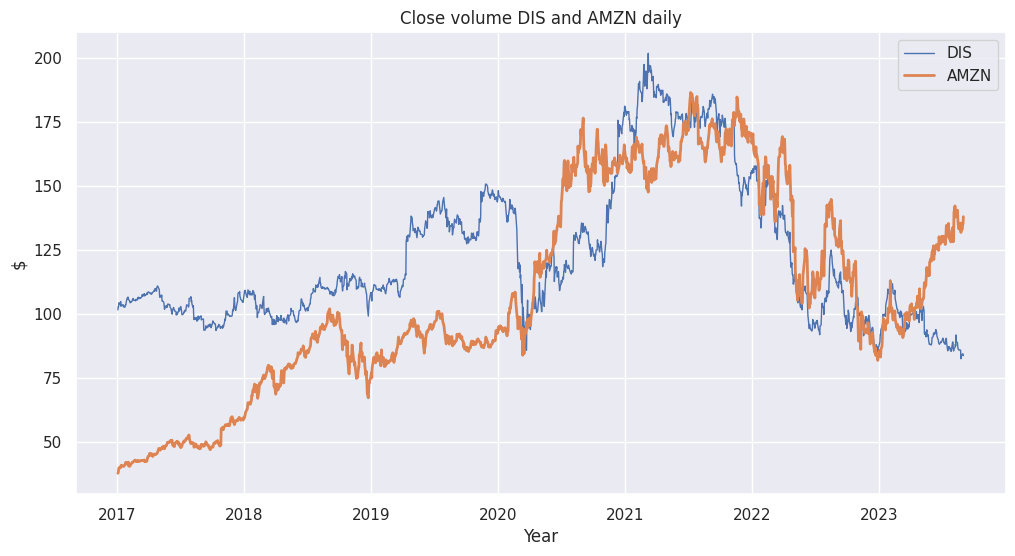

In [165]:
plt.figure(figsize=(12, 6))
plt.title('Close volume DIS and AMZN daily')
plt.xlabel('Year')
plt.ylabel('$')
plt.plot(df_dis['Close'],label = 'DIS', linewidth=1.0)
plt.plot(df_am['Close'], label = 'AMZN', linewidth=2.0)
plt.legend()
plt.show()

On plot we can see general view last 5 years. We are begining data analysis step by step now.

We usually have some tasks: to find T (trend), S (seasonal), C (cycle) and stationary (I can mistake in names, sorry, I am learning).

And - DIS. Micky, get ready!

In [166]:
df_dis.drop(['Open', 'High', 'Low', 'Volume'], axis = 1, inplace = True) #my goal is Close price (I had some troubles with parametrs, but I won)


In [167]:
df_dis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1677 entries, 2017-01-03 00:00:00-05:00 to 2023-08-31 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1677 non-null   float64
dtypes: float64(1)
memory usage: 26.2 KB


In [168]:
dis_decomposed = seasonal_decompose(df_dis, model='multiplicative', period = 365) #my period is year, we have not same price changes and because my model is multiplicative


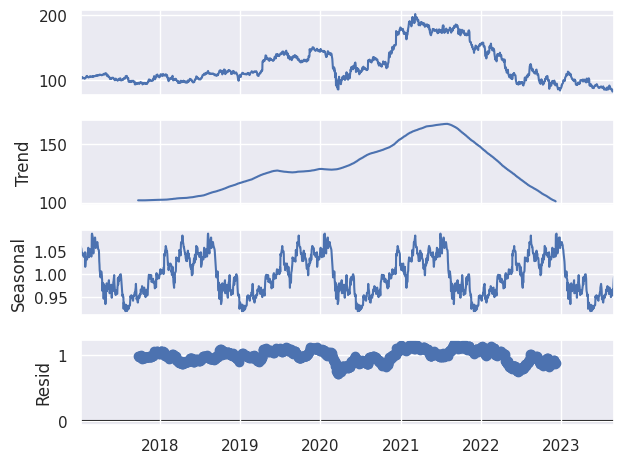

In [169]:
fig = dis_decomposed.plot()
plt.show();

We can see that:
1.   we don't have Trend for all period, but if we show only parts of 2017-2023 (for example 2017 -2021 or 2022-2023) we get uptrend in first case and downtrend in second.
2.   Seasonal: yes, we have near year seasonal.



Next step is finding of stationary. And we have to make stationary in negative case.

In [170]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [171]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [172]:
series = df_dis ['Close']

Results of Dickey-Fuller Test:
Test Statistic                   -1.419081
p-value                           0.573095
#Lags Used                        9.000000
Number of Observations Used    1667.000000
Critical Value (1%)              -3.434279
Critical Value (5%)              -2.863275
Critical Value (10%)             -2.567694
dtype: float64


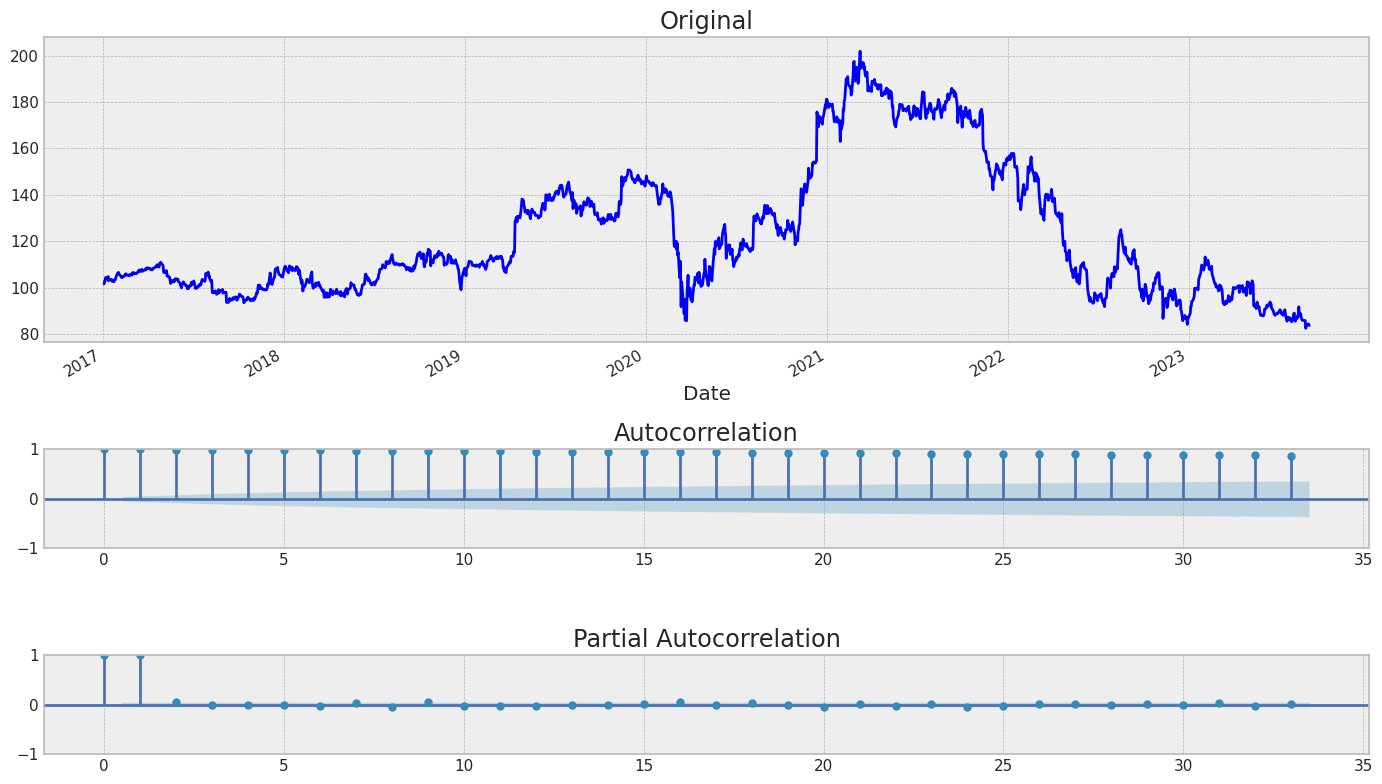

In [173]:
tsplot(series)

It isn't stationary.

In [174]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                   -1.443948
p-value                           0.561035
#Lags Used                        9.000000
Number of Observations Used    1667.000000
Critical Value (1%)              -3.434279
Critical Value (5%)              -2.863275
Critical Value (10%)             -2.567694
dtype: float64


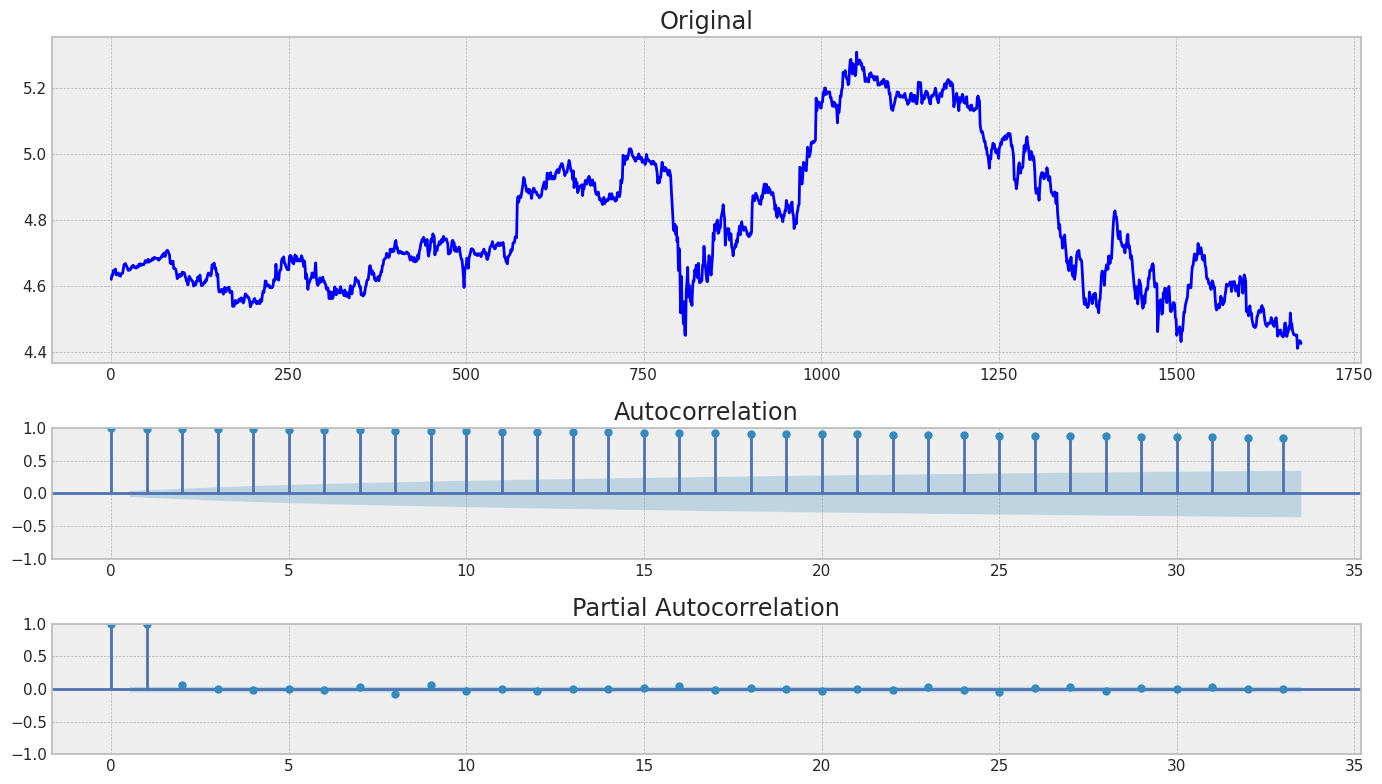

In [175]:
tsplot(series)

In [176]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.313819e+01
p-value                        1.447527e-24
#Lags Used                     8.000000e+00
Number of Observations Used    1.667000e+03
Critical Value (1%)           -3.434279e+00
Critical Value (5%)           -2.863275e+00
Critical Value (10%)          -2.567694e+00
dtype: float64


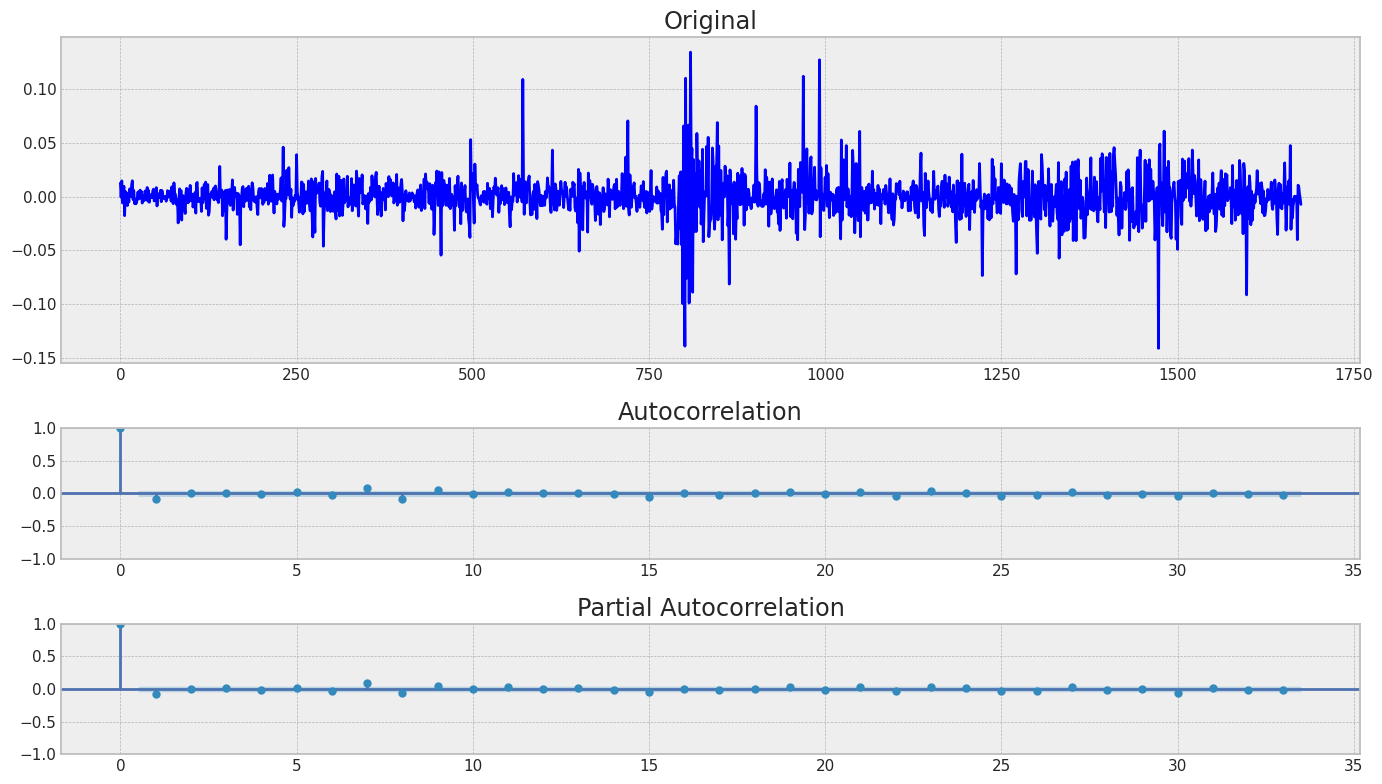

In [177]:
tsplot(series)

now it's stationary.

Time for our second company.

In [178]:
df_am.drop(['Open', 'High', 'Low', 'Volume'], axis = 1, inplace = True)

In [179]:
am_decomposed_1 = seasonal_decompose(df_am, model='multiplicative', period = 365)

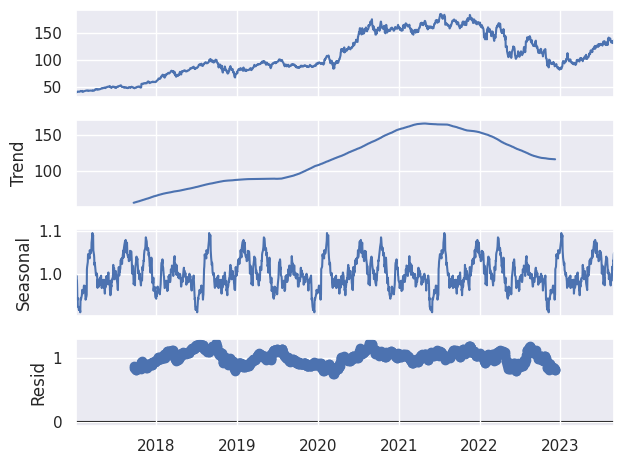

In [180]:
fig = am_decomposed_1.plot()
plt.show();

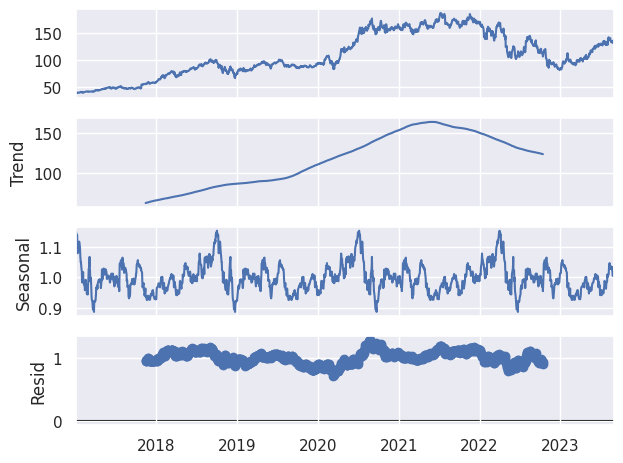

In [181]:
am_decomposed_2 = seasonal_decompose(df_am, model='multiplicative', period = 440) #I tried to do experiment and show period near 1,5 years, seasonal component is longer, but it's in place too
fig = am_decomposed_2.plot()
plt.show();


1.  we don't have Trend for all period, but if we show only parts of 2017-2023 (for example 2017 - medium of 2021) we get uptrend in this case.
2.  Seasonal: yes, we have near year seasonal.

Next step is finding of stationary. And we have to make stationary in negative case.

In [191]:
series_am = df_am['Close']

Results of Dickey-Fuller Test:
Test Statistic                   -1.773879
p-value                           0.393505
#Lags Used                        0.000000
Number of Observations Used    1676.000000
Critical Value (1%)              -3.434258
Critical Value (5%)              -2.863266
Critical Value (10%)             -2.567689
dtype: float64


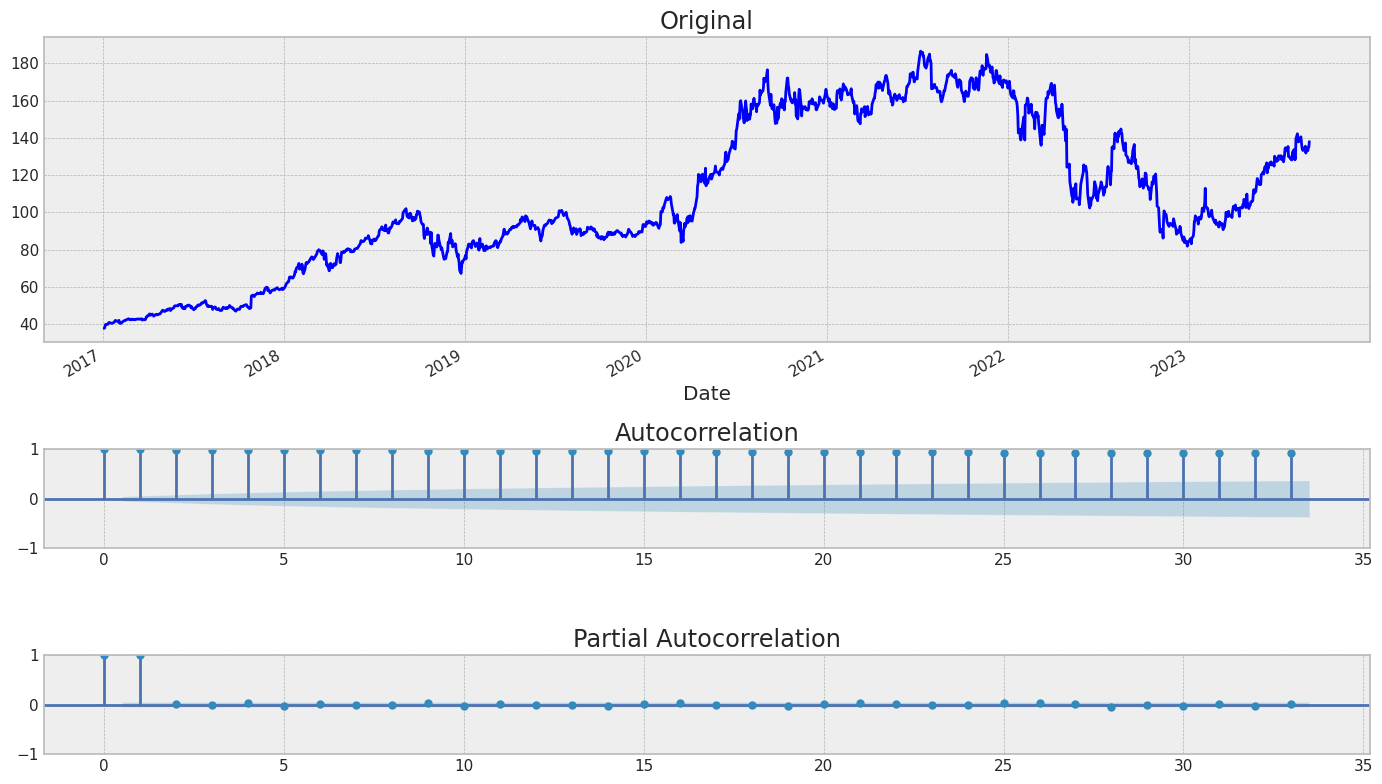

In [192]:
tsplot (series_am)

it isn't stationary

In [193]:
series_am = boxcox(series_am, 0)

Results of Dickey-Fuller Test:
Test Statistic                   -2.278288
p-value                           0.179066
#Lags Used                        0.000000
Number of Observations Used    1676.000000
Critical Value (1%)              -3.434258
Critical Value (5%)              -2.863266
Critical Value (10%)             -2.567689
dtype: float64


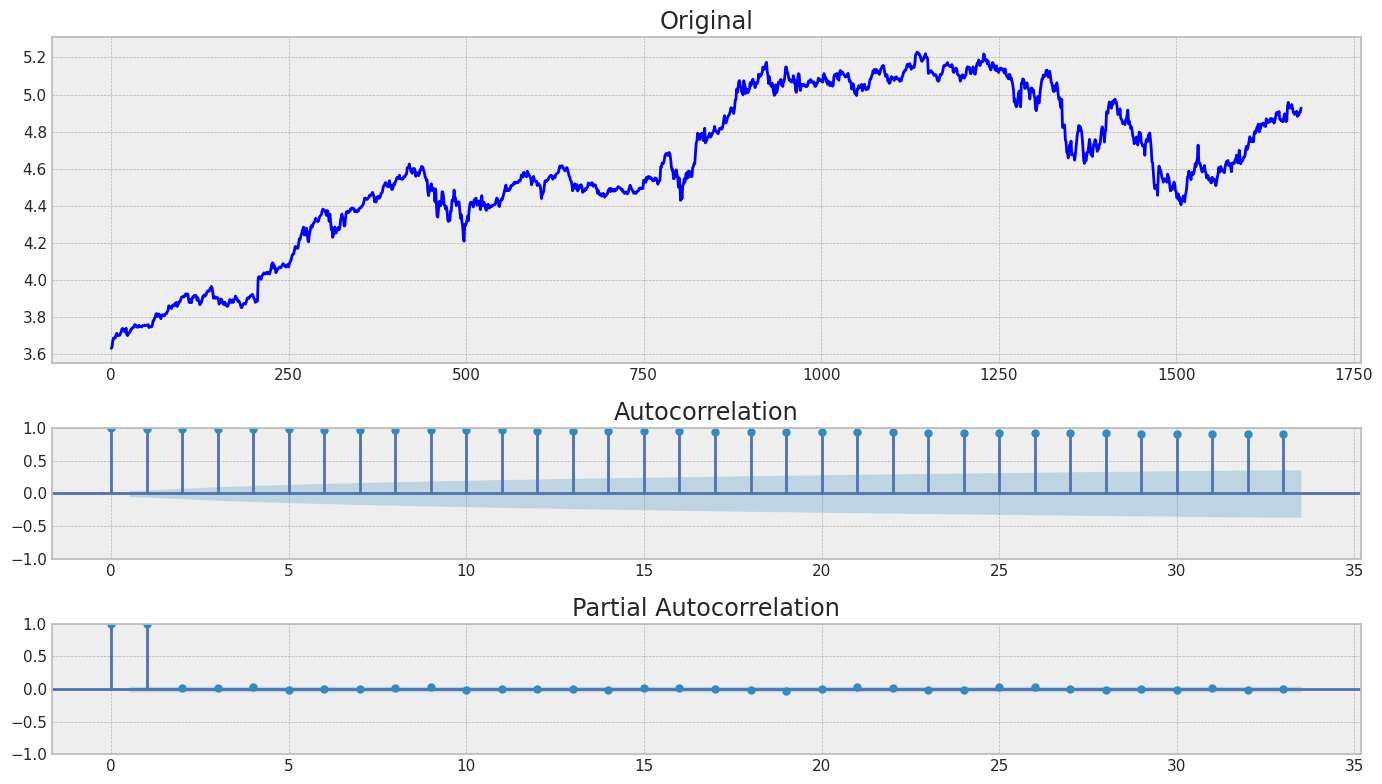

In [194]:
tsplot (series_am)

In [195]:
series_am = series_am[1:] - series_am[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.425573e+01
p-value                        1.455113e-26
#Lags Used                     8.000000e+00
Number of Observations Used    1.667000e+03
Critical Value (1%)           -3.434279e+00
Critical Value (5%)           -2.863275e+00
Critical Value (10%)          -2.567694e+00
dtype: float64


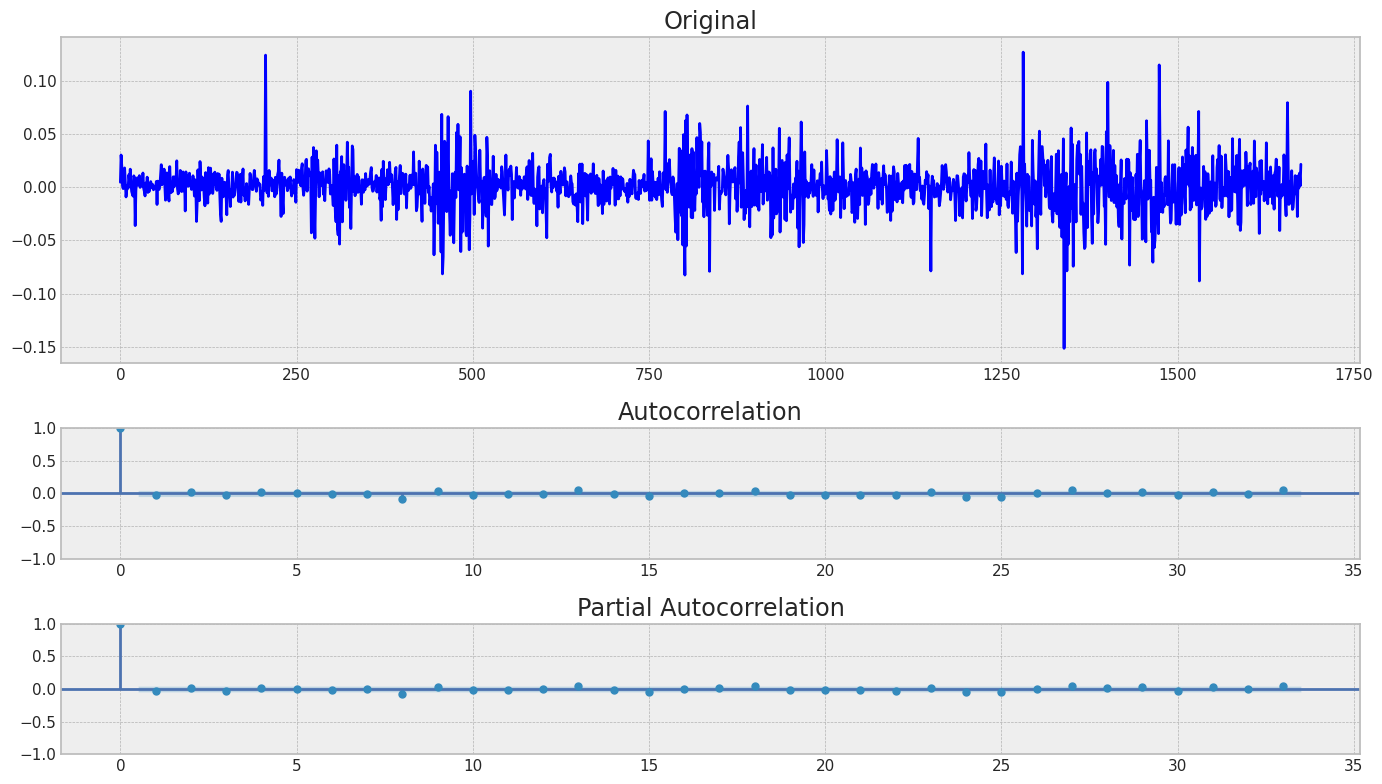

In [196]:
tsplot(series_am)

now it's stationary

and at last I wand to see about possible prediction for next part of my homework

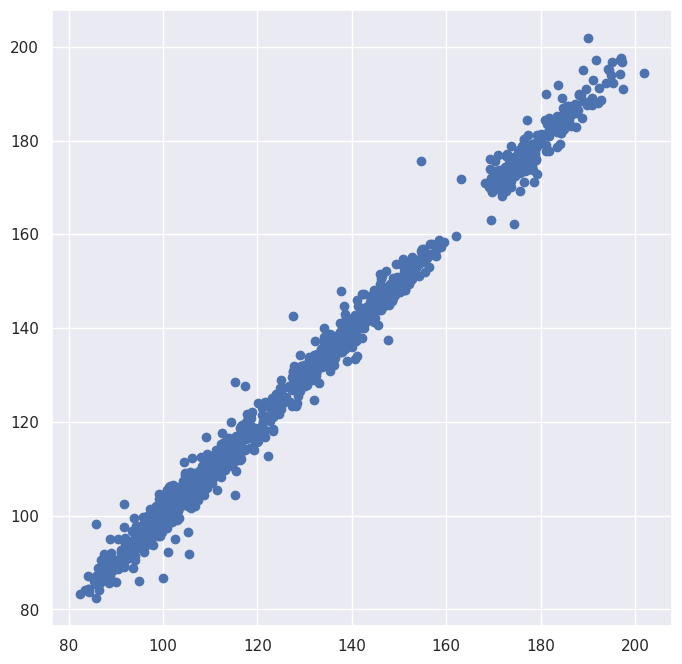

In [197]:
x = df_dis['Close'][:-1]
y = df_dis['Close'][1:]
plt.figure(figsize=(8,8))
plt.scatter(x,y)
plt.show()

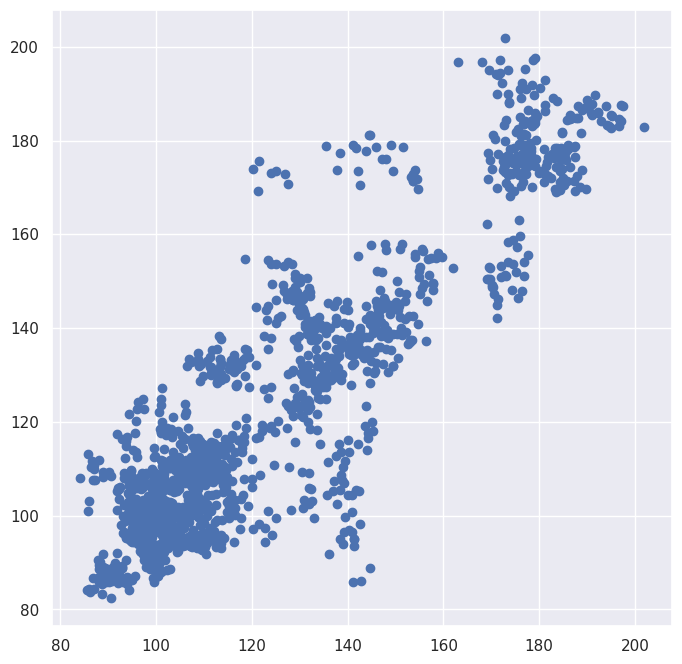

In [203]:
x = df_dis['Close'][:-30]
y = df_dis['Close'][30:]
plt.figure(figsize=(8,8))
plt.scatter(x,y)
plt.show()

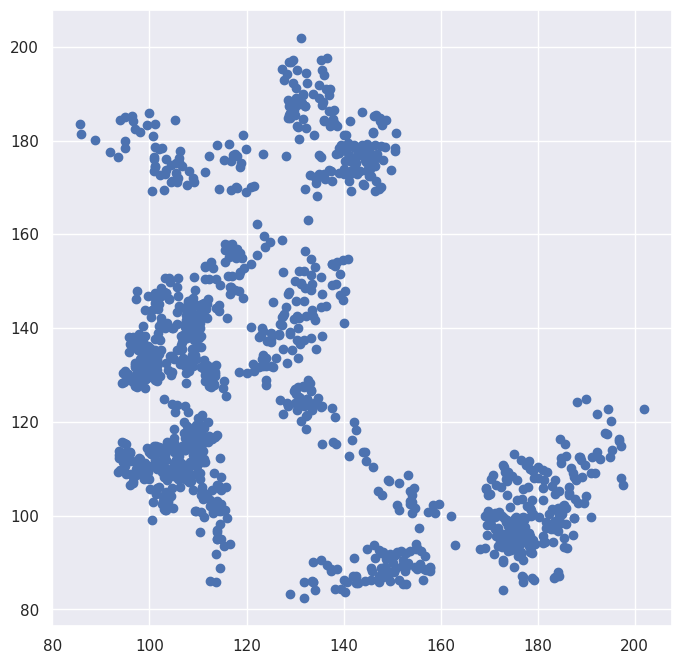

In [204]:
x = df_dis['Close'][:-365]
y = df_dis['Close'][365:]
plt.figure(figsize=(8,8))
plt.scatter(x,y)
plt.show()

Для анализа были выбраны показатели стоимости акций на конец дня корпорации Disney и Amazon в период с 1 января 2017 до 31 августа 2023гг.
Оба ряда не были стационарными, в обоих рядах не было равномерного тренда (но он прослеживался в определенные периоды), присутствовала сезонность (окологодовая).

При анализе автокорреляции - зависимость только по предыдущему дню, зависимость более чем через месяц отсутствует (у компании Disney).

Путем преобразований (бокс-кокс и дифференцирование) удалось добиться стационарности временного ряда.

